In [1]:
%load_ext autoreload

In [31]:
%autoreload 2
from copy import deepcopy
from delase import DeLASE
from delase.metrics import mase
import h5py
from hydra import compose, initialize
from matplotlib import font_manager
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.stats import mannwhitneyu, pearsonr
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import MDS
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
import sys
from tqdm.auto import tqdm

sys.path.append('../..')
from data_utils import filter_data, find_noisy_data, get_delase_results, get_delase_run_list, get_grid_search_results, get_grid_search_run_list, get_grid_search_window_ts, get_section_info, load_session_data, load_window_from_chunks, resection_grid_results
from hdf5_utils import TransposedDatasetView

plt.style.use('/home/eisenaj/code/UniversalUnconsciousness/sci_style.mplstyle')
font_path = "/home/eisenaj/miniforge3/envs/communication-jacobians/fonts/arial.ttf"
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

sys.path.append('/home/eisenaj/code/UniversalUnconsciousness/DeLASE_analysis')
from run_delase_across_hypers import main

In [3]:
with initialize(version_base="1.3", config_path="../../DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [4]:
data_class = cfg.params.data_class
session_list = [f[:-4] for f in os.listdir(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat')) if f.endswith('.mat')]
session_list = [session for session in session_list if session not in ['PEDRI_Ketamine_20220203']]

# session_list = [session_list[1]]
# session_list = [session_list[2]]
# session_list = ['SPOCK_Ketamine_20210712', 'PEDRI_Ketamine_20220106', "PEDRI_Ketamine_20220222"]
# session_list = ['PEDRI_Ketamine_20220106']
# session_list = ["PEDRI_Ketamine_20220222"]

session_list = [session for session in session_list if 'Dex' not in session]

session_list = ['SPOCK_Ketamine_20210707',
 'SPOCK_Ketamine_20210802',
 'PEDRI_Ketamine_20220209',
 'PEDRI_Ketamine_20220224']


In [5]:
# session_groups = {
#     'SPOCK': {
#         1.0: [],
#         10.0: []
#     },
#     'PEDRI': {
#         1.0: [],
#         10.0: []
#     }
# }

# for session in session_list:
#     session_file = h5py.File(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat', f"{session}.mat"), 'r')
#     monkey = session.split('_')[0]
#     dose = session_file['sessionInfo']['dose'][0][0]
#     session_groups[monkey][dose].append(session)

# print(session_groups)

In [6]:
# session_list_filtered = []
# for monkey, doses in session_groups.items():
#     for dose, sessions in doses.items():
#         selected_sessions = sessions[:2]  # Select the first two sessions for each monkey/dose combo
#         session_list_filtered.extend(selected_sessions)

# session_list = session_list_filtered


In [7]:
# areas = ['vlPFC', 'dlPFC', '-R', '-L']
# areas = ['all', 'vlPFC', 'FEF', '7b', 'CPB']
areas = ['all']

In [8]:
session_list

['SPOCK_Ketamine_20210707',
 'SPOCK_Ketamine_20210802',
 'PEDRI_Ketamine_20220209',
 'PEDRI_Ketamine_20220224']

# Filter out Noise

In [9]:
noise_filter_info = {}
if cfg.params.noise_filter:
    os.makedirs(cfg.params.noise_filter_results_dir, exist_ok=True)
    for session in session_list:
        noise_filter_dir = os.path.join(cfg.params.noise_filter_results_dir, cfg.params.data_class)
        os.makedirs(noise_filter_dir, exist_ok=True)
        noise_filter_file = f"{session}__window_{cfg.params.window}__wakethresh_{cfg.params.wake_amplitude_thresh}__anesthesiathresh_{cfg.params.anesthesia_amplitude_thresh}__electrodenum_{cfg.params.electrode_num_thresh}.pkl"
        
        print("--------------------")
        print(f"Session: {session}")
        print("--------------------")
        if noise_filter_file in os.listdir(noise_filter_dir):
            noise_filter_info[session] = pd.read_pickle(os.path.join(noise_filter_dir, noise_filter_file))
        else:
            print("Finding noisy data...")
            window_df, bad_electrodes, valid_window_starts = find_noisy_data(cfg, session)
            noise_filter_info[session] = dict(
                window_df=window_df,
                bad_electrodes=bad_electrodes,
                valid_window_starts=valid_window_starts
            )
            pd.to_pickle(noise_filter_info[session], os.path.join(noise_filter_dir, noise_filter_file))
        
        print(f"{len(noise_filter_info[session]['bad_electrodes'])} bad electrodes, {len(noise_filter_info[session]['valid_window_starts'])} valid windows (out of {len(noise_filter_info[session]['window_df'])} total windows)")
else:
    bad_electrodes = []
    valid_window_starts = None
    noise_filter_info = dict(
        window_df=None,
        bad_electrodes=bad_electrodes,
        valid_window_starts=valid_window_starts
    )

--------------------
Session: SPOCK_Ketamine_20210707
--------------------
14 bad electrodes, 1317 valid windows (out of 1336 total windows)
--------------------
Session: SPOCK_Ketamine_20210802
--------------------
16 bad electrodes, 344 valid windows (out of 793 total windows)
--------------------
Session: PEDRI_Ketamine_20220209
--------------------
19 bad electrodes, 883 valid windows (out of 1073 total windows)
--------------------
Session: PEDRI_Ketamine_20220224
--------------------
17 bad electrodes, 534 valid windows (out of 793 total windows)


## PCA

In [10]:
if cfg.params.pca:
    pca_chosen = {}
    for session in session_list:
        section_info, section_info_extended, section_colors, infusion_start = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class)
        
        print("-"*20)
        print(f"SESSION = {session}")
        print("-"*20)
    
        normed_folder = 'NOT_NORMED' if not cfg.params.normed else 'NORMED'
        filter_folder = f"[{cfg.params.high_pass},{cfg.params.low_pass}]" if cfg.params.low_pass is not None or cfg.params.high_pass is not None else 'NO_FILTER'
    
        pca_dir = os.path.join(cfg.params.grid_search_results_dir, cfg.params.data_class, "PCA_info", session, normed_folder, f"SUBSAMPLE_{cfg.params.subsample}", filter_folder, f"WINDOW_{cfg.params.window}")
        os.makedirs(pca_dir, exist_ok=True)
    
        pca_chosen[session] = {}
        for area in areas:
    
            # Get the relevant indices for each area
            os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
            variables = ['electrodeInfo']
            session_vars, T, N, dt = load_session_data(session, cfg.params.all_data_dir, variables, data_class=cfg.params.data_class, verbose=False)
            electrode_info = session_vars['electrodeInfo']
    
            if area == 'all':
                dimension_inds = np.arange(len(electrode_info['area']))
            else:
                # dimension_inds = np.where(electrode_info['area'] == area)[0]
                dimension_inds = np.where([area in area_entry for area_entry in electrode_info['area']])[0]
            dimension_inds = np.array([d for d in dimension_inds if d not in noise_filter_info[session]['bad_electrodes']])

            # Get PCA explained variance ratios
            area_pca_file = os.path.join(pca_dir, area)
            if os.path.exists(area_pca_file):
                print(f"Found PCA info for {session}: {area}")
                pca_explained_variance_ratios = pd.read_pickle(area_pca_file)
            else:
                print(f"Computing PCA info for {session}: {area}")
                grid_search_window_start_ts = get_grid_search_window_ts(session, cfg.params.all_data_dir, cfg.params.data_class, section_info, cfg.params.num_windows_per_section, window_radius=30, valid_window_starts=noise_filter_info[session]['valid_window_starts'], random_state=cfg.params.random_state)
    
                directory = pd.read_pickle(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, f"{session}_lfp_chunked_20s", "directory"))
            
                pca_explained_variance_ratios = {}
                for t in tqdm(grid_search_window_start_ts, desc=f'Doing PCA for {session}: {area}'):
                    lfp = load_window_from_chunks(t, t + cfg.params.window, directory=directory, dimension_inds=dimension_inds)
                    lfp = lfp[::cfg.params.subsample]
                    # filter
                    lfp = filter_data(lfp, cfg.params.low_pass, cfg.params.high_pass, dt*cfg.params.subsample)
                    
                    pca = PCA(n_components=lfp.shape[1]).fit(lfp)
                    pca_explained_variance_ratios[t] = pca.explained_variance_ratio_
    
                pd.to_pickle(pca_explained_variance_ratios, area_pca_file)
    
            # pick the max number of PCs across windows greater than the threshold
            pca_chosen[session][area] = np.max([np.argmax(np.cumsum(evr) >= cfg.params.pca_thresh) for evr in pca_explained_variance_ratios.values()])
else:
    pca_chosen = None

# Collect Indices to Run

In [11]:
all_indices_to_run = {}
for session in tqdm(session_list, desc='Getting Grid Search Run List'):
    print("-"*20)
    print(f"SESSION = {session}")
    print("-"*20)
    section_info, section_info_extended, section_colors, infusion_start = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class)
    grid_search_window_start_ts = get_grid_search_window_ts(cfg, session, valid_window_starts=noise_filter_info[session]['valid_window_starts'], random_state=cfg.params.random_state)
    # grid_search_window_start_ts = get_grid_search_window_ts(session, cfg.params.all_data_dir, cfg.params.data_class, section_info, cfg.params.num_windows_per_section, window_radius=30, valid_window_starts=noise_filter_info[session]['valid_window_starts'], random_state=cfg.params.random_state)
    normed_folder = 'NOT_NORMED' if not cfg.params.normed else 'NORMED'
    filter_folder = f"[{cfg.params.high_pass},{cfg.params.low_pass}]" if cfg.params.low_pass is not None or cfg.params.high_pass is not None else 'NO_FILTER'
    grid_search_run_list = get_grid_search_run_list(cfg, session, grid_search_window_start_ts, noise_filter_info[session]['bad_electrodes'], verbose=True)
    # grid_search_run_list = get_grid_search_run_list(session, os.path.join(cfg.params.grid_search_results_dir, cfg.params.data_class), cfg.params.all_data_dir, cfg.params.window, cfg.grid_sets[cfg.params.grid_set], cfg.params.grid_set, grid_search_window_start_ts, cfg.params.T_pred, group_ranks=cfg.params.group_ranks, bad_electrodes=noise_filter_info[session]['bad_electrodes'], verbose=True, random_state=cfg.params.random_state)
    noise_filter_folder = f"NOISE_FILTERED_{cfg.params.window}_{cfg.params.wake_amplitude_thresh}_{cfg.params.anesthesia_amplitude_thresh}_{cfg.params.electrode_num_thresh}" if cfg.params.noise_filter else "NO_NOISE_FILTER"

    for area in areas:
        
        pca_folder = "NO_PCA" if not cfg.params.pca else f"PCA_{pca_chosen[session][area]}"
        save_dir = os.path.join(cfg.params.grid_search_results_dir, cfg.params.data_class, 'grid_search_results', session, noise_filter_folder, normed_folder, f"SUBSAMPLE_{cfg.params.subsample}", filter_folder, f"WINDOW_{cfg.params.window}", cfg.params.grid_set, area, pca_folder)

        os.makedirs(save_dir, exist_ok=True)
        
        saved_files = os.listdir(save_dir)

        
        if not cfg.params.group_ranks:
            # filter runs for those with valid rank
            filtered_run_list = []
            for run_index, run_info in enumerate(grid_search_run_list[area]):
                if cfg.params.pca:
                    n_dims = pca_chosen[session][area]
                else:
                    n_dims = len(run_info['dimension_inds'])
                    if run_info['n_delays']*n_dims >= run_info['rank']:
                        run_info['run_index'] = run_index
                        filtered_run_list.append(run_info)
        else: # runs don't need to be filtered
            filtered_run_list = []
            for run_index, run_info in enumerate(grid_search_run_list[area]):
                run_info['run_index'] = run_index
                filtered_run_list.append(run_info)
        
        indices_to_run = []
        for run_info in filtered_run_list:
            filename = f"run_index-{run_info['run_index']}.pkl"
            if filename not in saved_files:
                indices_to_run.append(run_info['run_index'])
    
        if len(indices_to_run) == 0:
            print(f"*COMPLETE*: All results completed for {session} - {area}!!")
        elif len(indices_to_run) == len(filtered_run_list):
            print(f"NOT STARTED: no results completed for {session} - {area}. Adding all indices! ({len(indices_to_run)})")
            if session not in all_indices_to_run:
                all_indices_to_run[session] = {}
            all_indices_to_run[session][area] = indices_to_run
        else:
            print(f"INCOMPLETE: {session} - {area} incomplete, adding indices {indices_to_run}")
            if session not in all_indices_to_run:
                all_indices_to_run[session] = {}
            all_indices_to_run[session][area] = indices_to_run

Getting Grid Search Run List:   0%|          | 0/4 [00:00<?, ?it/s]

--------------------
SESSION = SPOCK_Ketamine_20210707
--------------------
list exists! loading /orcd/data/ekmiller/001/eisenaj/UniversalUnconsciousness/grid_searches/anesthesiaLvrOdd/grid_search_run_lists/SPOCK_Ketamine_20210707_grid_set4_window_15...
*COMPLETE*: All results completed for SPOCK_Ketamine_20210707 - all!!
--------------------
SESSION = SPOCK_Ketamine_20210802
--------------------
list exists! loading /orcd/data/ekmiller/001/eisenaj/UniversalUnconsciousness/grid_searches/anesthesiaLvrOdd/grid_search_run_lists/SPOCK_Ketamine_20210802_grid_set4_window_15...
*COMPLETE*: All results completed for SPOCK_Ketamine_20210802 - all!!
--------------------
SESSION = PEDRI_Ketamine_20220209
--------------------
list exists! loading /orcd/data/ekmiller/001/eisenaj/UniversalUnconsciousness/grid_searches/anesthesiaLvrOdd/grid_search_run_lists/PEDRI_Ketamine_20220209_grid_set4_window_15...
*COMPLETE*: All results completed for PEDRI_Ketamine_20220209 - all!!
--------------------
SESSION

# Running

In [12]:
os.chdir('/home/eisenaj/code/UniversalUnconsciousness')
batch_size = 250

In [13]:
sessions_to_run = list(all_indices_to_run.keys())
# sessions_to_run = sessions_to_run[:4]

# iterator = tqdm(total=np.sum([len(all_indices_to_run[session]) for session in sessions_to_run]), desc='Hydra Multiprocessing - DSA on Neural Data')
iterator = tqdm(total=np.sum([np.sum([int(np.ceil(len(all_indices_to_run[session][area])/batch_size)) for area in all_indices_to_run[session].keys()]) for session in sessions_to_run]), desc='Hydra Multiprocessing - Grid Search on Neural Data')

for session in sessions_to_run:
    for area in all_indices_to_run[session].keys():
        print(f"Running indices for {session} - {area}")
        num_batches = int(np.ceil(len(all_indices_to_run[session][area])/batch_size))
        for batch_num in range(num_batches):
            batch_start = batch_num*batch_size
            batch_end = np.min([(batch_num + 1)*batch_size, len(all_indices_to_run[session][area])])
            print(f"running batch #{batch_num}")
            if cfg.params.pca:
                os.system(f"HYDRA_FULL_ERROR=1 python DeLASE_analysis/run_grid_search.py -m ++params.session={session} ++params.area={area} ++params.pca_dims={int(pca_chosen[session][area])} ++params.run_index={','.join([str(i) for i in all_indices_to_run[session][area][batch_start:batch_end]])}")
            else:
              os.system(f"HYDRA_FULL_ERROR=1 python DeLASE_analysis/run_grid_search.py -m ++params.session={session} ++params.area={area} ++params.run_index={','.join([str(i) for i in all_indices_to_run[session][area][batch_start:batch_end]])}")
            iterator.update()
iterator.close()

Hydra Multiprocessing - Grid Search on Neural Data: 0it [00:00, ?it/s]

# Collect Grid Search Results

In [14]:
cfg.params.stat_to_use = 'aic'

In [15]:
section_info, section_info_extended, section_colors, infusion_start = get_section_info(session_list[0], cfg.params.all_data_dir, cfg.params.data_class)

In [16]:
grid_search_results = get_grid_search_results(cfg, session_list, areas, len(section_info), pca_chosen)

list exists! loading /orcd/data/ekmiller/001/eisenaj/UniversalUnconsciousness/grid_searches/anesthesiaLvrOdd/grid_search_run_lists/SPOCK_Ketamine_20210707_grid_set4_window_15...
list exists! loading /orcd/data/ekmiller/001/eisenaj/UniversalUnconsciousness/grid_searches/anesthesiaLvrOdd/grid_search_run_lists/SPOCK_Ketamine_20210802_grid_set4_window_15...
list exists! loading /orcd/data/ekmiller/001/eisenaj/UniversalUnconsciousness/grid_searches/anesthesiaLvrOdd/grid_search_run_lists/PEDRI_Ketamine_20220209_grid_set4_window_15...
list exists! loading /orcd/data/ekmiller/001/eisenaj/UniversalUnconsciousness/grid_searches/anesthesiaLvrOdd/grid_search_run_lists/PEDRI_Ketamine_20220224_grid_set4_window_15...


In [17]:
# sections_to_use = ['awake oddball', 'unconscious oddball', 'recovery oddball']
grid_search_results = resection_grid_results(cfg, grid_search_results, cfg.params.sections_to_use)

In [18]:
session = session_list[0]
area = areas[0]

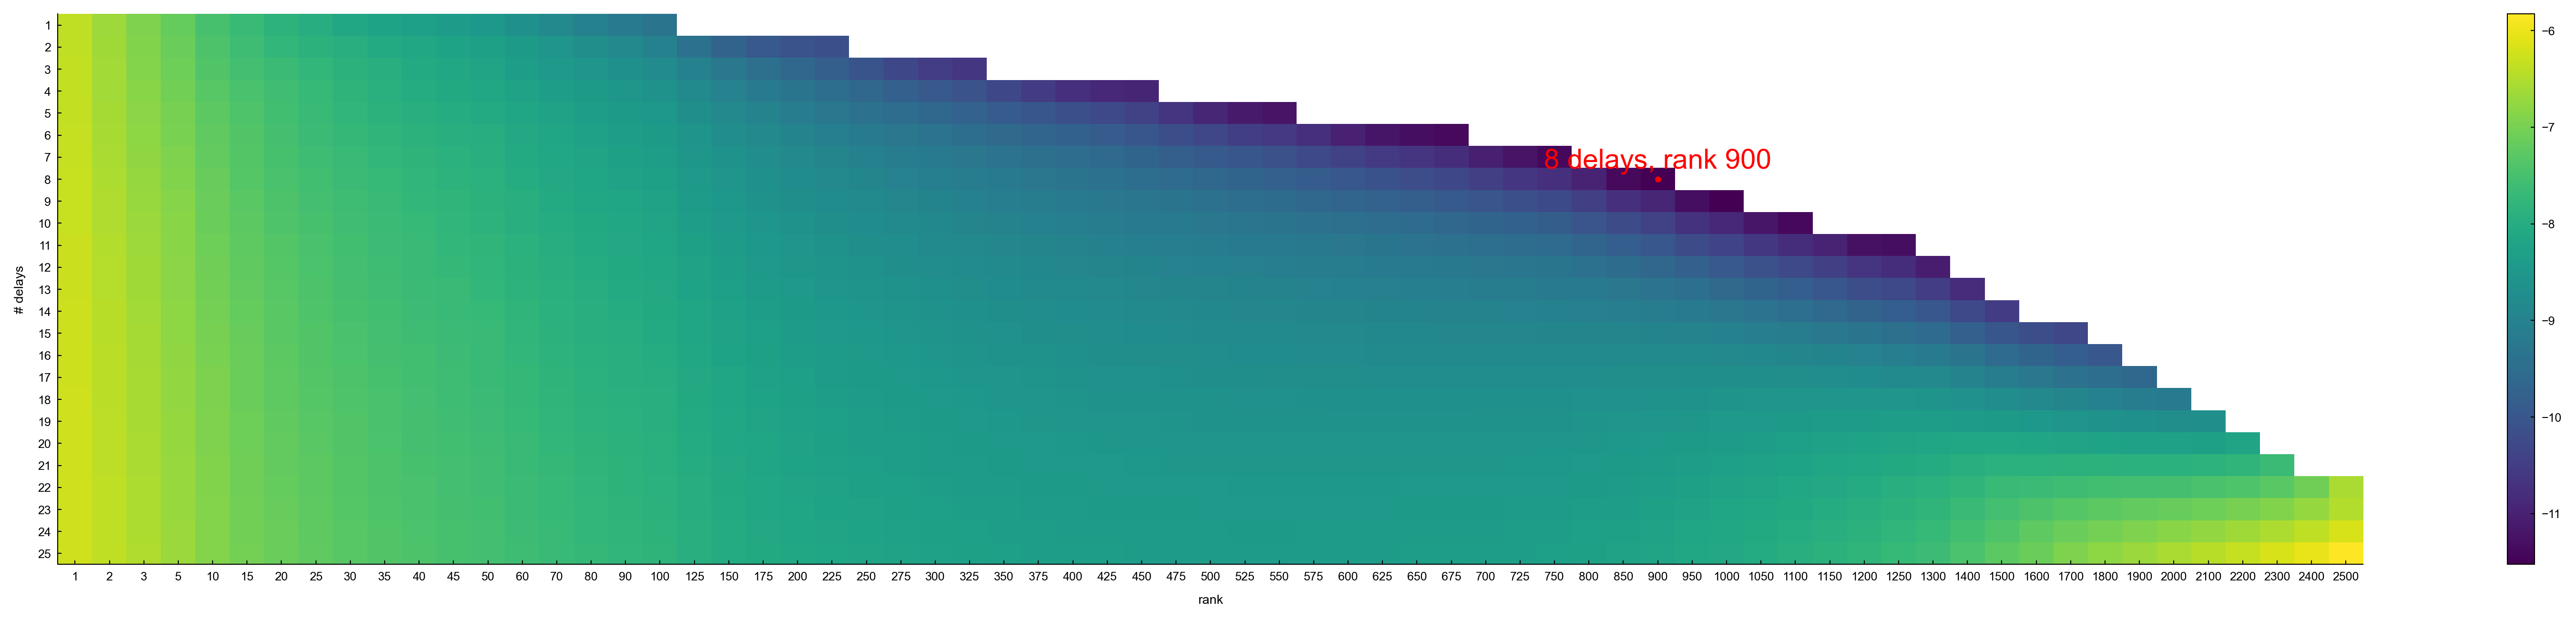

In [19]:
plt.figure(figsize=(26, 5))

nan_vec = np.isnan(grid_search_results[session][area]['mats'][cfg.params.stat_to_use][0, -1])
if np.sum(nan_vec) == 0:
    n_ranks = len(nan_vec)
else:
    n_ranks = np.argmax(nan_vec)
results_to_show = deepcopy(grid_search_results[session][area]['mats'][cfg.params.stat_to_use][:, :, :n_ranks])
# results_to_show[results_to_show == 0] = np.nan

im = plt.imshow(results_to_show.mean(axis=0), aspect='auto')
i, j = grid_search_results[session][area]['i'], grid_search_results[session][area]['j']
plt.scatter(j, i, c='r')
n_delays = grid_search_results[session][area]['n_delays']
rank = grid_search_results[session][area]['rank']
plt.text(j, i - 0.5, f"{n_delays} delays, rank {rank}", c='r', ha='center', fontsize=14)
plt.xticks(np.arange(len(cfg.grid_sets[cfg.params.grid_set].rank_vals))[:n_ranks], cfg.grid_sets[cfg.params.grid_set].rank_vals[:n_ranks])
plt.yticks(np.arange(len(cfg.grid_sets[cfg.params.grid_set].n_delays_vals)), cfg.grid_sets[cfg.params.grid_set].n_delays_vals)
plt.ylabel('# delays')
plt.xlabel('rank')
plt.colorbar(im)
plt.show()

In [20]:
grid_params_to_use = {}
for session in session_list:
    grid_params_to_use[session] = {}
    for area in areas:
        grid_params_to_use[session][area] = {'n_delays': grid_search_results[session][area]['n_delays'], 'rank': grid_search_results[session][area]['rank']}


# Get DeLASE Run List

In [21]:
sections_to_run = ['awake oddball', 'unconscious oddball', 'recovery oddball']

n_delays_max = 10
rank_max = 1100
n_delays_vals = np.array(cfg.grid_sets[cfg.params.grid_set].n_delays_vals)[np.array(cfg.grid_sets[cfg.params.grid_set].n_delays_vals) <= n_delays_max]
rank_vals = np.array(cfg.grid_sets[cfg.params.grid_set].rank_vals)[np.array(cfg.grid_sets[cfg.params.grid_set].rank_vals) <= rank_max]

all_indices_to_run = {}
for session in tqdm(session_list, desc='Getting DeLASE Run List'):
    print("-"*20)
    print(f"SESSION = {session}")
    print("-"*20)
    delase_run_list = get_delase_run_list(cfg, session, valid_window_starts=noise_filter_info[session]['valid_window_starts'], bad_electrodes=noise_filter_info[session]['bad_electrodes'])
    section_info, section_info_extended, section_colors, infusion_start = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class)

    noise_filter_folder = f"NOISE_FILTERED_{cfg.params.window}_{cfg.params.wake_amplitude_thresh}_{cfg.params.anesthesia_amplitude_thresh}_{cfg.params.electrode_num_thresh}" if cfg.params.noise_filter else "NO_NOISE_FILTER"
    normed_folder = 'NOT_NORMED' if not cfg.params.normed else 'NORMED'
    filter_folder = f"[{cfg.params.high_pass},{cfg.params.low_pass}]" if cfg.params.low_pass is not None or cfg.params.high_pass is not None else 'NO_FILTER'

    for area in areas:
        # Get filtered run list for this area
        filtered_run_list = []
        for section_name, (section_start_min, section_end_min) in section_info:
            if section_name not in sections_to_run:
                continue
            # Convert section times from minutes to seconds and add infusion_start offset
            section_start_sec = section_start_min * 60 + infusion_start
            section_end_sec = section_end_min * 60 + infusion_start
            for run in delase_run_list[area]:
                if run['window_start'] >= section_start_sec and run['window_end'] <= section_end_sec:
                    filtered_run_list.append(run)
        print(f"Filtered run list for {session} - {area} has {len(filtered_run_list)} runs")
        # Track indices to run for each hyperparameter combination
        all_indices = []  # Changed from set() to list since we have unhashable lists
        for n_delays in n_delays_vals:
            for run_info in filtered_run_list:
                # Get all valid ranks for this n_delays value
                valid_ranks = []
                for rank in rank_vals:
                    if rank <= n_delays * len(run_info['dimension_inds']):
                        valid_ranks.append(rank)
                
                # Check if any results are missing for this run_index/n_delays combination
                missing_results = False
                for rank in valid_ranks:
                    grid_folder = f"GRID_RESULTS_n_delays_{n_delays}_rank_{rank}"
                    pca_folder = "NO_PCA" if not cfg.params.pca else f"PCA_{pca_chosen[session][area]}"
                    save_dir = os.path.join(cfg.params.delase_results_dir, cfg.params.data_class, 'delase_results', session, noise_filter_folder, normed_folder, f"SUBSAMPLE_{cfg.params.subsample}", filter_folder, f"WINDOW_{cfg.params.window}", grid_folder, f"STRIDE_{cfg.params.stride}", area, pca_folder)

                    os.makedirs(save_dir, exist_ok=True)
                    filename = f"run_index-{run_info['i']}.pkl"
                    if filename not in os.listdir(save_dir):
                        missing_results = True
                        break

                if missing_results:
                    all_indices.append((run_info['i'], n_delays, tuple(valid_ranks)))  # Convert list to tuple to make it hashable

        # find number of valid n_delays values
        print(f"Number of valid n_delays values: {len(n_delays_vals)}")
        print(f"Number of possible indices to run: {len(filtered_run_list) * len(n_delays_vals)}")

        if len(all_indices) > 0:
            if session not in all_indices_to_run:
                all_indices_to_run[session] = {}
            all_indices_to_run[session][area] = all_indices
            if len(all_indices) == len(filtered_run_list) * len(n_delays_vals):
                print(f"NOT STARTED: no results completed for {session} - {area}. Adding all indices! ({len(all_indices)})")
            else:
                print(f"INCOMPLETE: {session} - {area} incomplete, adding {len(all_indices)} indices")
        else:
            print(f"*COMPLETE*: All results completed for {session} - {area}!!")

Getting DeLASE Run List:   0%|          | 0/4 [00:00<?, ?it/s]

--------------------
SESSION = SPOCK_Ketamine_20210707
--------------------
Filtered run list for SPOCK_Ketamine_20210707 - all has 185 runs
Number of valid n_delays values: 10
Number of possible indices to run: 1850
*COMPLETE*: All results completed for SPOCK_Ketamine_20210707 - all!!
--------------------
SESSION = SPOCK_Ketamine_20210802
--------------------
Filtered run list for SPOCK_Ketamine_20210802 - all has 106 runs
Number of valid n_delays values: 10
Number of possible indices to run: 1060
*COMPLETE*: All results completed for SPOCK_Ketamine_20210802 - all!!
--------------------
SESSION = PEDRI_Ketamine_20220209
--------------------
Filtered run list for PEDRI_Ketamine_20220209 - all has 150 runs
Number of valid n_delays values: 10
Number of possible indices to run: 1500
*COMPLETE*: All results completed for PEDRI_Ketamine_20220209 - all!!
--------------------
SESSION = PEDRI_Ketamine_20220224
--------------------
Filtered run list for PEDRI_Ketamine_20220224 - all has 147 run

### Run

In [22]:
os.chdir('/home/eisenaj/code/UniversalUnconsciousness')
batch_size = 25

In [23]:
sessions_to_run = list(all_indices_to_run.keys())
# sessions_to_run = sessions_to_run[:4]

# iterator = tqdm(total=np.sum([len(all_indices_to_run[session]) for session in sessions_to_run]), desc='Hydra Multiprocessing - DSA on Neural Data')
iterator = tqdm(total=np.sum([np.sum([int(np.ceil(len(all_indices_to_run[session][area])/batch_size)) for area in all_indices_to_run[session].keys()]) for session in sessions_to_run]), desc='Hydra Multiprocessing - Grid Search on Neural Data')

for session in sessions_to_run:
    for area in all_indices_to_run[session].keys():
        print(f"Running indices for {session} - {area}")
        num_batches = int(np.ceil(len(all_indices_to_run[session][area])/batch_size))
        for batch_num in range(num_batches):
            batch_start = batch_num*batch_size
            batch_end = np.min([(batch_num + 1)*batch_size, len(all_indices_to_run[session][area])])
            print(f"running batch #{batch_num}")
            
            # Get the run indices, n_delays, and ranks for this batch
            batch_indices = all_indices_to_run[session][area][batch_start:batch_end]
            run_indices = [x[0] for x in batch_indices]
            n_delays = batch_indices[0][1]  # All entries in batch should have same n_delays
            ranks = batch_indices[0][2]  # All entries in batch should have same ranks tuple
            
            if cfg.params.pca:
                os.system(f"HYDRA_FULL_ERROR=1 python DeLASE_analysis/run_delase_across_hypers.py -m ++params.session={session} ++params.area={area} ++params.pca_dims={int(pca_chosen[session][area])} ++params.n_delays={n_delays} ++params.rank=[{','.join([str(int(r)) for r in ranks])}] ++params.run_index={','.join([str(i) for i in run_indices])}")
            else:
                os.system(f"HYDRA_FULL_ERROR=1 python DeLASE_analysis/run_delase_across_hypers.py -m ++params.session={session} ++params.area={area} ++params.n_delays={n_delays} ++params.rank=[{','.join([str(int(r)) for r in ranks])}] ++params.run_index={','.join([str(i) for i in run_indices])}")
            iterator.update()
iterator.close()

Hydra Multiprocessing - Grid Search on Neural Data: 0it [00:00, ?it/s]

# Collect DeLASE Results

In [25]:
delase_results = {}
total_iterations = sum(1 
                      for session in session_list 
                      for area in areas if area in grid_params_to_use[session]
                      for n_delays in n_delays_vals 
                      for rank in rank_vals if rank <= n_delays * (h5py.File(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat', f"{session}.mat"))['lfp'].shape[0] - len(noise_filter_info[session]['bad_electrodes'])))

with tqdm(total=total_iterations, desc='Getting DeLASE results across hyperparameters') as pbar:
    for session in session_list:
        delase_results[session] = {}
        num_dimensions = h5py.File(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat', f"{session}.mat"))['lfp'].shape[0] - len(noise_filter_info[session]['bad_electrodes'])
        for area in areas:
            if area not in grid_params_to_use[session]:
                continue
                
            area_results = []
            for n_delays in [int(n_delays) for n_delays in n_delays_vals]:
                for rank in [int(rank) for rank in rank_vals]:
                    if rank > n_delays * num_dimensions:
                        continue
                    # Get results for this hyperparameter combination
                    result_df = get_delase_results(cfg, [session], [area], 
                                                 {session: {area: {'n_delays': n_delays, 'rank': rank}}},
                                                 pca_chosen)
                    
                    # Add hyperparameter columns
                    result_df[session][area]['n_delays'] = n_delays
                    result_df[session][area]['rank'] = rank
                    
                    area_results.append(result_df[session][area])
                    pbar.update(1)
                    
            # Concatenate all results for this area
            delase_results[session][area] = pd.concat(area_results, ignore_index=True)

Getting DeLASE results across hyperparameters:   0%|          | 0/1456 [00:00<?, ?it/s]

# Fourier Analysis

In [95]:
# Set random seed
np.random.seed(cfg.params.random_state)

# Initialize dictionary to store fourier results by section
fourier_results = {
    'awake oddball': {},
    'unconscious oddball': {},
    'recovery oddball': {}
}

sections_of_interest = ['awake oddball', 'unconscious oddball', 'recovery oddball']
n_windows = 50

# Create progress bar for total iterations
total_its = len(session_list) * len(areas) * len(sections_of_interest) * n_windows
iterator = tqdm(total=total_its, desc='Calculating Fourier transforms')

for session in session_list:
    session_file = h5py.File(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat', f"{session}.mat"))
    lfp = TransposedDatasetView(session_file['lfp']).transpose()
    dt = session_file['lfpSchema']['smpInterval'][0, 0]
    
    # Get section information
    section_info, section_info_extended, section_colors, infusion_start = get_section_info(
        session, cfg.params.all_data_dir, cfg.params.data_class
    )

    section_info_dict = {name: times for name, times in section_info}
    
    for area in areas:
        if area in delase_results[session]:
            # Initialize section results if not already done
            for section in sections_of_interest:
                if session not in fourier_results[section]:
                    fourier_results[section][session] = {}
                if area not in fourier_results[section][session]:
                    fourier_results[section][session][area] = []
            
            # Get windows for each section
            for section in sections_of_interest:
                # Get windows that fall within this section
                section_windows = delase_results[session][area]
                # Filter windows within section bounds
                section_windows = section_windows[
                    (section_windows.window_start >= section_info_dict[section][0]*60 + infusion_start) &
                    (section_windows.window_end <= section_info_dict[section][1]*60 + infusion_start)
                ]
                if len(section_windows) > 0:
                    # Randomly sample n_windows unique window starts
                    unique_starts = section_windows.window_start.unique()
                    if len(unique_starts) > n_windows:
                        selected_starts = np.random.choice(unique_starts, n_windows, replace=False)
                    else:
                        selected_starts = unique_starts
                    # Calculate FFT for each selected window
                    for window_start in selected_starts:
                        window_data = section_windows[section_windows.window_start == window_start].iloc[0]
                        data = lfp[
                            int(window_data.window_start/dt):int(window_data.window_end/dt), 
                            window_data.dimension_inds
                        ]
                        fft_avg = np.abs(np.fft.rfft(data, axis=0)).mean(axis=1)
                        fourier_results[section][session][area].append(fft_avg)
                        iterator.update(1)

iterator.close()


Calculating Fourier transforms:   0%|          | 0/600 [00:00<?, ?it/s]

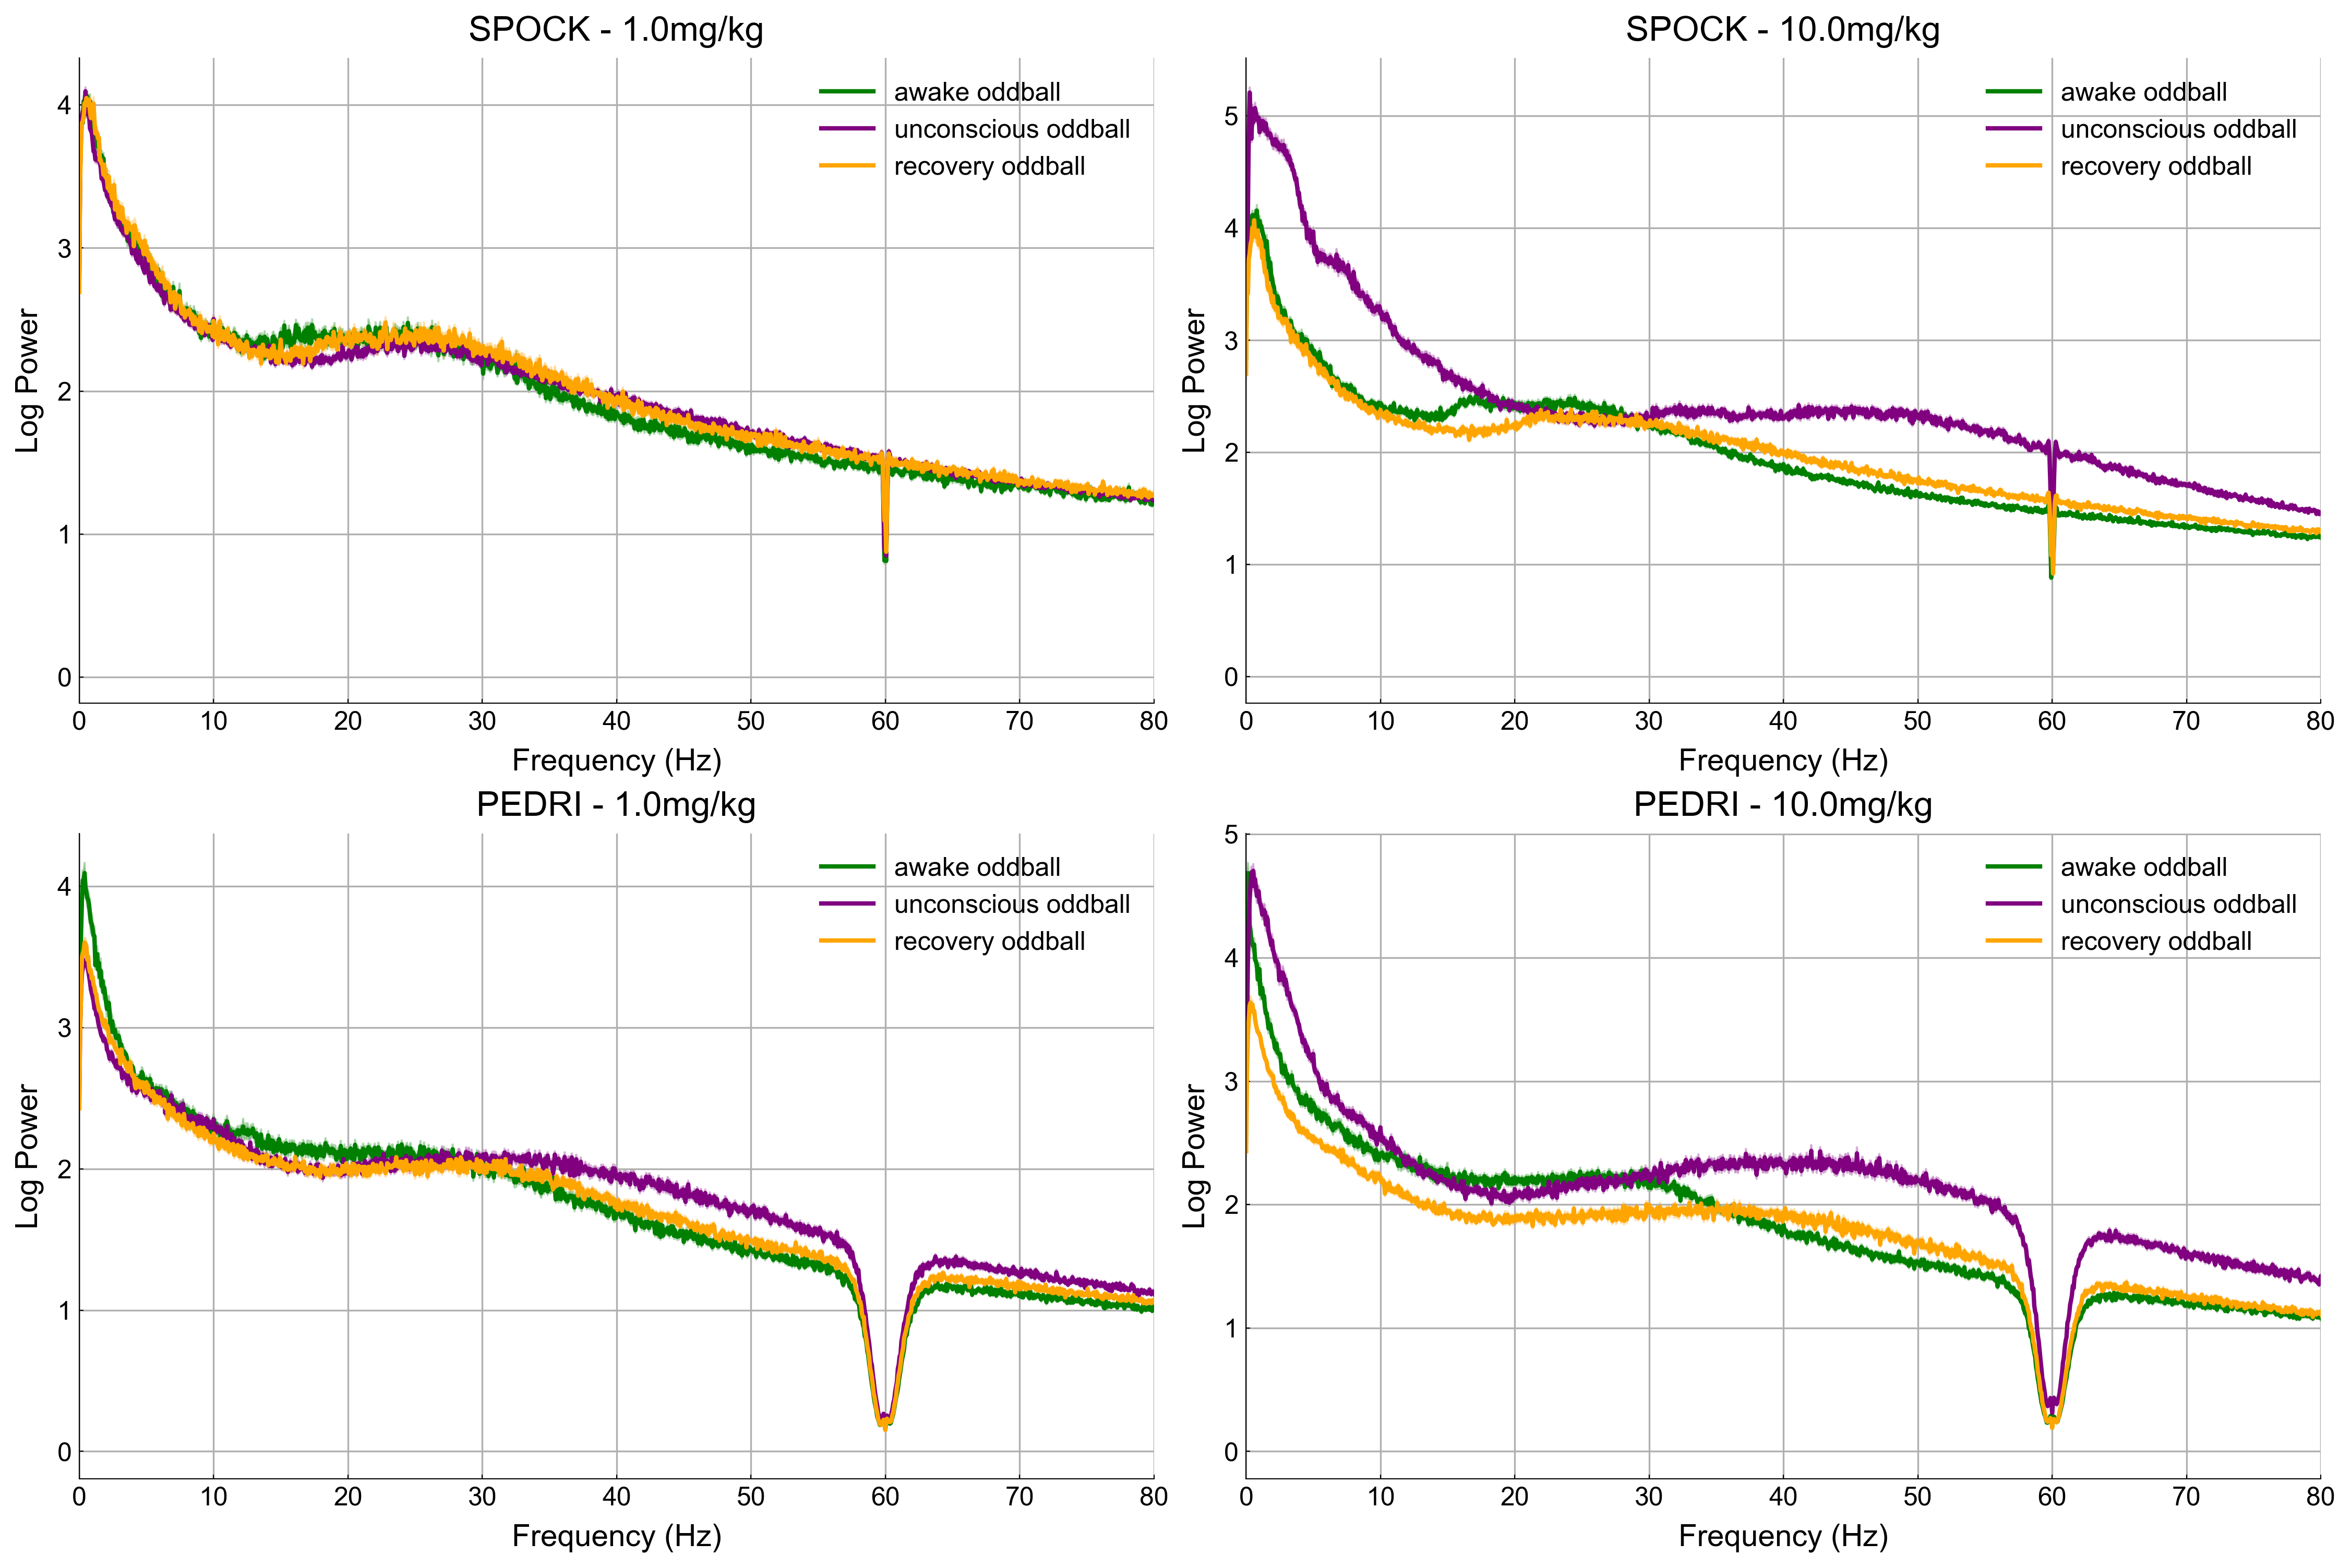

In [96]:
# Set up plotting
plt.figure(figsize=(15,10))

# Define colors for sections
section_colors = {
    'awake oddball': 'green',
    'unconscious oddball': 'purple', 
    'recovery oddball': 'orange'
}

# Define monkeys and doses
monkeys = ['SPOCK', 'PEDRI']
doses = ['1.0', '10.0']

# Plot for each monkey/dose combination
for i, monkey in enumerate(monkeys):
    for j, dose in enumerate(doses):
        plt.subplot(2, 2, i*2 + j + 1)
        
        # Get relevant sessions
        relevant_sessions = [s for s in fourier_results['awake oddball'].keys() 
                           if s.startswith(f'{monkey}_Ketamine_') and h5py.File(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat', f"{s}.mat"))['sessionInfo']['dose'][0, 0] == float(dose)]
        
        # Plot each section
        for section in ['awake oddball', 'unconscious oddball', 'recovery oddball']:
            # Collect all FFTs for this monkey/dose/section
            all_ffts = []
            for session in relevant_sessions:
                for area in fourier_results[section][session].keys():
                    if len(fourier_results[section][session][area]) > 0:
                        all_ffts.extend(fourier_results[section][session][area])
            
            if len(all_ffts) > 0:
                # Average across all windows
                mean_fft = np.mean(all_ffts, axis=0)
                # Calculate standard error
                std_fft = np.std(all_ffts, axis=0)
                se_fft = std_fft / np.sqrt(len(all_ffts))
                # Log transform the mean FFT
                mean_fft_log = np.log1p(mean_fft)  # log1p for log(1 + x) to handle zero values
                se_fft_log = se_fft / (mean_fft + 1)  # Adjust standard error for log scale
                
                plt.plot(fft_freqs, mean_fft_log, color=section_colors[section], 
                         label=section, linewidth=2)
                plt.fill_between(fft_freqs, 
                                 mean_fft_log - se_fft_log, 
                                 mean_fft_log + se_fft_log, 
                                 color=section_colors[section], alpha=0.3)

        plt.xlim(0, 80)  # Limit x-axis to 0-30 Hz
        plt.title(f'{monkey} - {dose}mg/kg', fontsize=16)  # Increased fontsize
        plt.xlabel('Frequency (Hz)', fontsize=14)  # Increased fontsize
        plt.ylabel('Log Power', fontsize=14)  # Increased fontsize
        plt.legend(fontsize=12)  # Increased fontsize
        plt.grid(True)

        # Make ticks larger
        plt.tick_params(axis='both', which='major', labelsize=12)  # Increase major tick size
        plt.tick_params(axis='both', which='minor', labelsize=10)  # Increase minor tick size

plt.tight_layout()


/tmp/ipykernel_1839010/1072320870.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)  # Increased fontsize
/tmp/ipykernel_1839010/1072320870.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)  # Increased fontsize
/tmp/ipykernel_1839010/1072320870.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)  # Increased fontsize


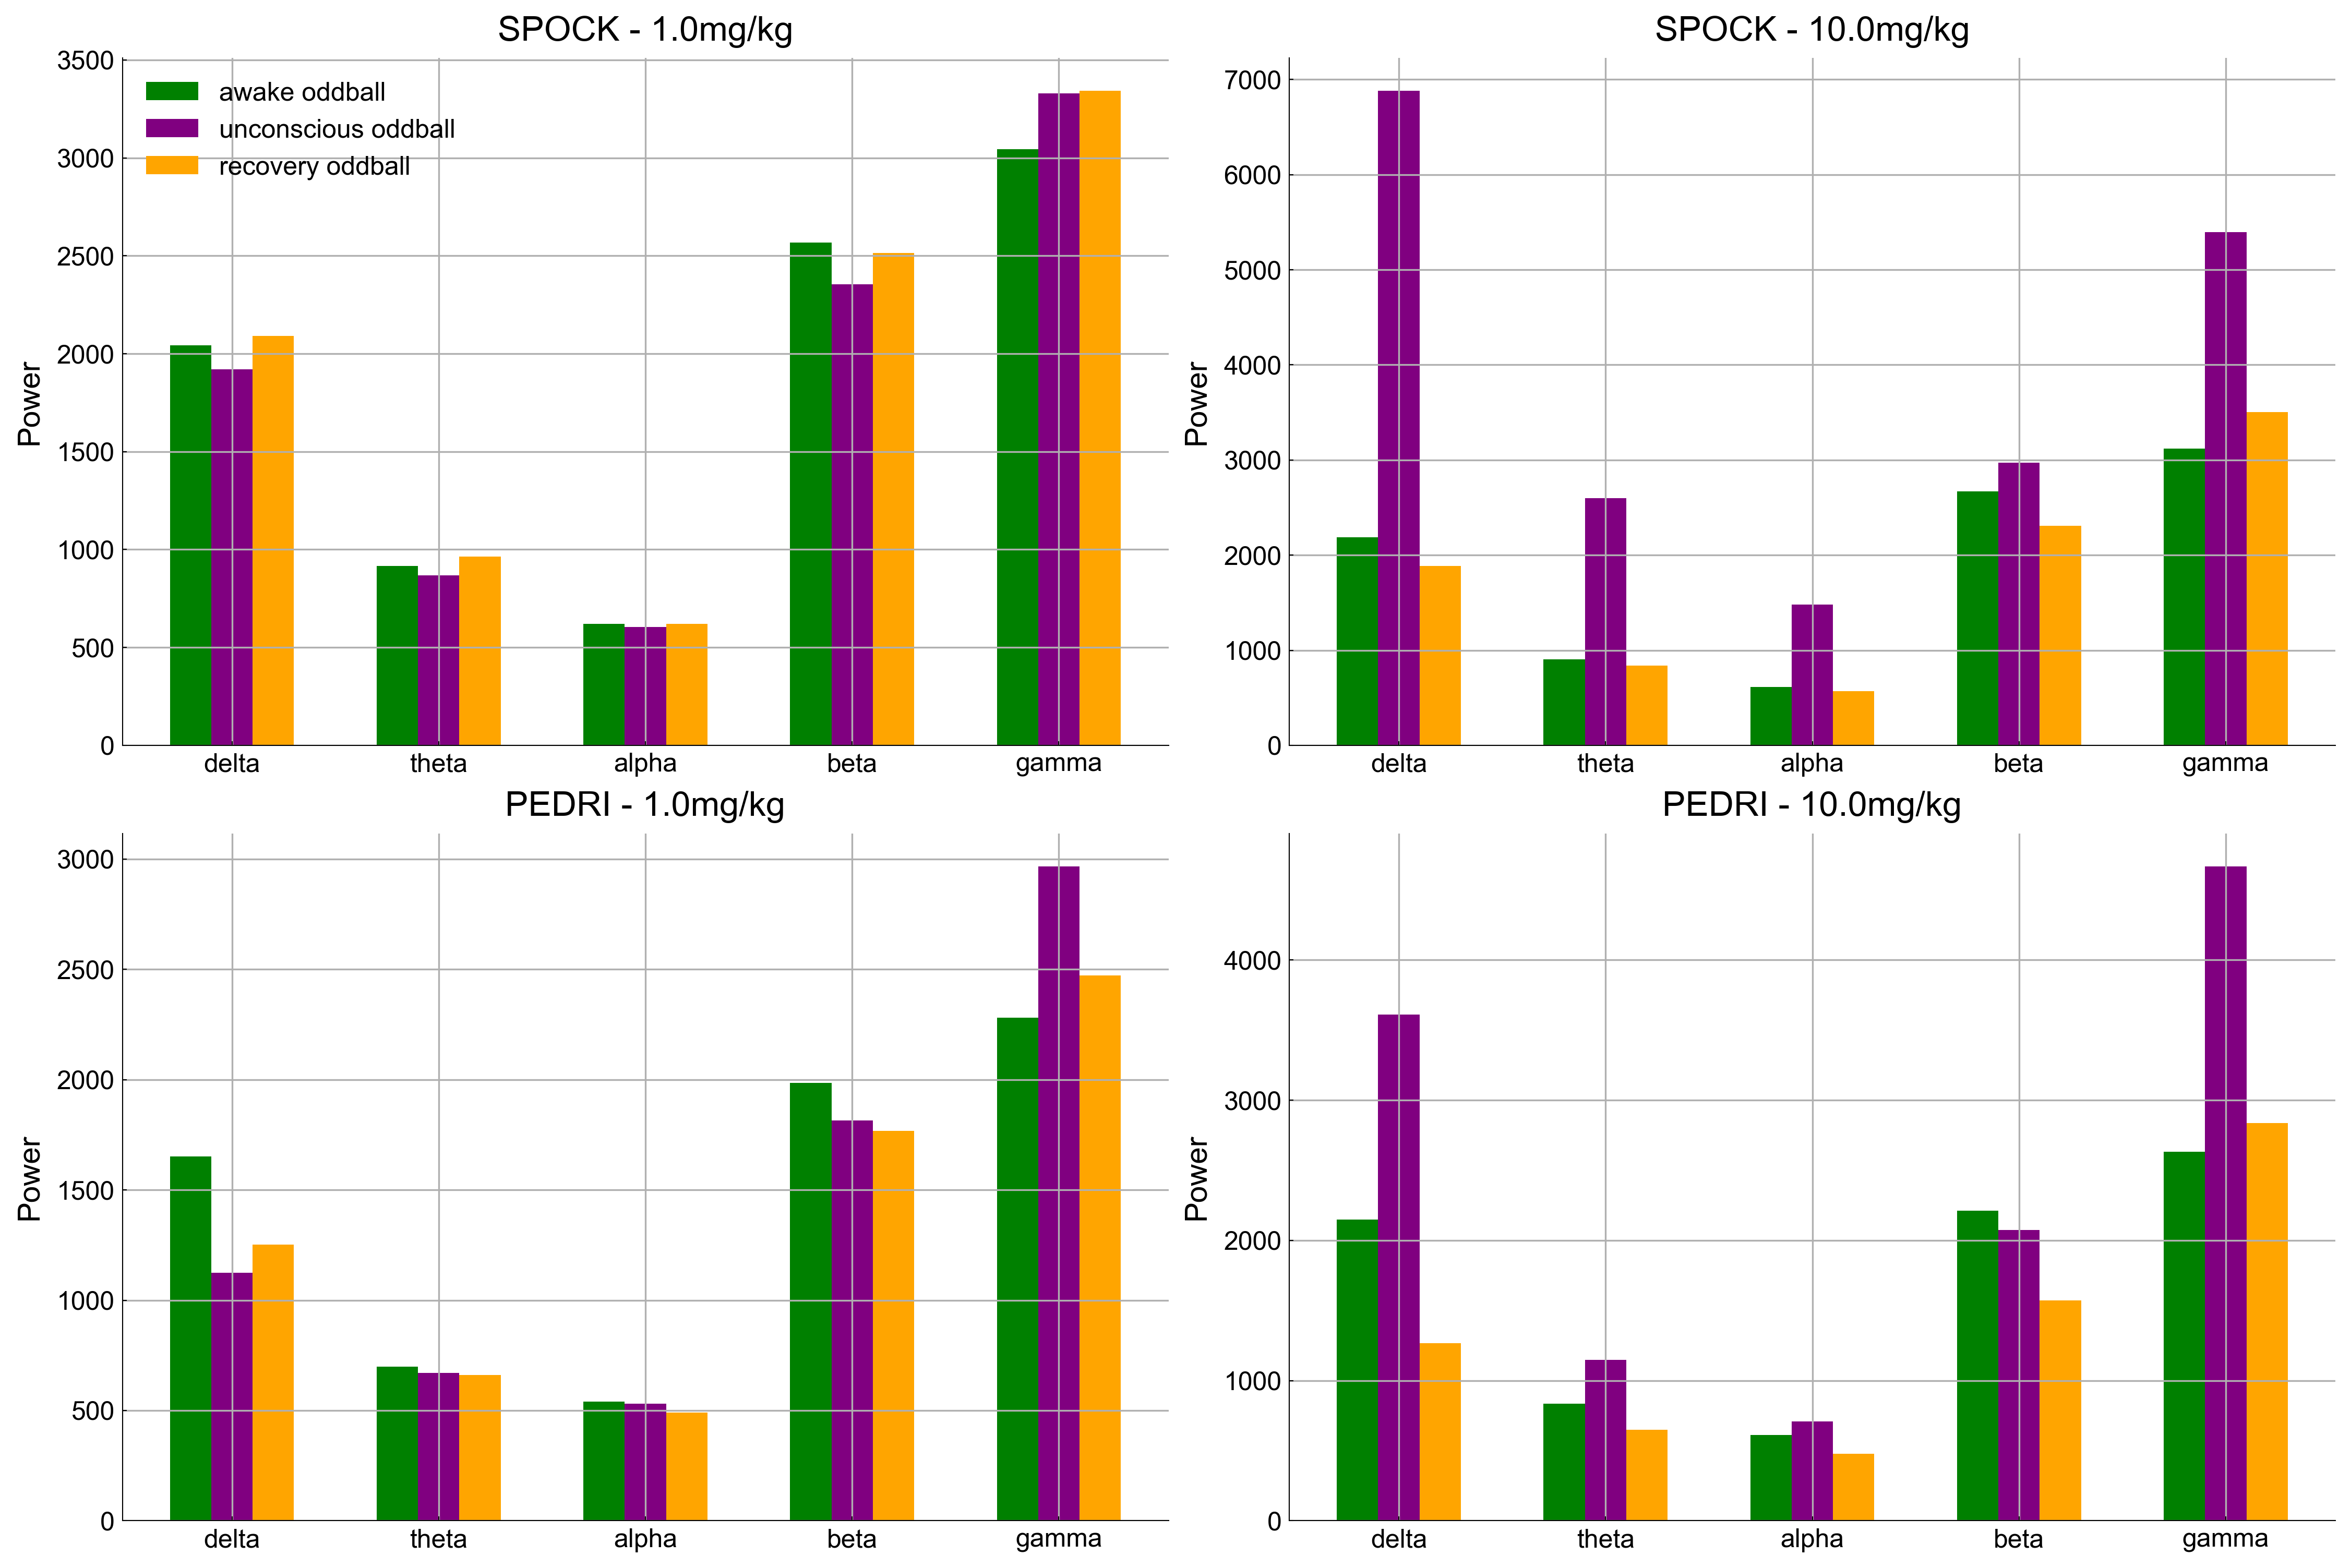

In [97]:
# Set up plotting
plt.figure(figsize=(15,10))

# Define colors for sections
section_colors = {
    'awake oddball': 'green',
    'unconscious oddball': 'purple', 
    'recovery oddball': 'orange'
}

# Define monkeys and doses
monkeys = ['SPOCK', 'PEDRI']
doses = ['1.0', '10.0']

# Define frequency bands
frequency_bands = {
    'delta': (0, 4),
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (12, 30),
    'gamma': (30, 80)
}

# Plot for each monkey/dose combination
for i, monkey in enumerate(monkeys):
    for j, dose in enumerate(doses):
        plt.subplot(2, 2, i*2 + j + 1)
        
        # Get relevant sessions
        relevant_sessions = [s for s in fourier_results['awake oddball'].keys() 
                           if s.startswith(f'{monkey}_Ketamine_') and h5py.File(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat', f"{s}.mat"))['sessionInfo']['dose'][0, 0] == float(dose)]
        
        # Initialize a dictionary to hold binned powers
        binned_powers = {band: {section: 0 for section in section_colors.keys()} for band in frequency_bands.keys()}
        
        # Collect all FFTs for this monkey/dose/section
        for section in ['awake oddball', 'unconscious oddball', 'recovery oddball']:
            all_ffts = []
            for session in relevant_sessions:
                for area in fourier_results[section][session].keys():
                    if len(fourier_results[section][session][area]) > 0:
                        all_ffts.extend(fourier_results[section][session][area])
            
            if len(all_ffts) > 0:
                # Average across all windows
                mean_fft = np.mean(all_ffts, axis=0)
                
                # Bin the powers into frequency bands
                for band, (low, high) in frequency_bands.items():
                    band_indices = np.where((fft_freqs >= low) & (fft_freqs < high))[0]
                    binned_powers[band][section] = np.sum(mean_fft[band_indices])
        
        # Create bars for each frequency band
        bar_width = 0.2  # Width of the bars
        x_positions = np.arange(len(frequency_bands))  # X positions for the frequency bands
        
        # Plot bars for each section
        for s_idx, section in enumerate(section_colors.keys()):
            plt.bar(x_positions + s_idx * bar_width,
                   [binned_powers[band][section] for band in frequency_bands.keys()],
                   width=bar_width,
                   color=section_colors[section],
                   label=section if i == 0 and j == 0 else "")
        
        plt.xticks(x_positions + bar_width, frequency_bands.keys())  # Set x-ticks to frequency band names
        plt.title(f'{monkey} - {dose}mg/kg', fontsize=16)  # Increased fontsize
        plt.ylabel('Power', fontsize=14)  # Increased fontsize
        plt.legend(fontsize=12)  # Increased fontsize
        plt.grid(True)

        # Make ticks larger
        plt.tick_params(axis='both', which='major', labelsize=12)  # Increase major tick size
        plt.tick_params(axis='both', which='minor', labelsize=10)  # Increase minor tick size

plt.tight_layout()


In [46]:
# fourier transform on window data
fft_freqs = np.fft.rfftfreq(len(window_data), dt)

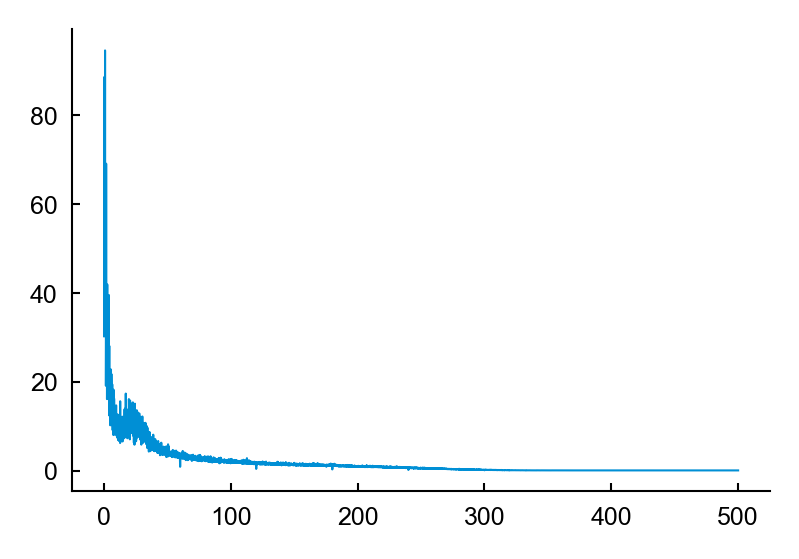

In [47]:
plt.plot(fft_freqs, fft_avg)